<a href="https://colab.research.google.com/github/TokushigeJunya/ForcedHNN/blob/main/Two_body_exp1%2C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import autograd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import random
solve_ivp = scipy.integrate.solve_ivp
from scipy.optimize import fsolve

def GL2(F,t,y,h):
    def func(z):
        F1 = np.zeros(y.size)
        F2 = np.zeros(y.size)
        F3 = np.zeros(y.size*2)
        F1 = F(t+(3-(3**0.5))*h/6,y+h*(z[:y.size]/4+(3-2*(3**0.5))*z[y.size:]/12))
        F2 = F(t+(3+(3**0.5))*h/6,y+h*((3+2*(3**0.5))*z[:y.size]/12+z[y.size:]/4))
        F3 = np.concatenate([F1,F2])
        return z-F3
    k = fsolve(func,np.concatenate([F(t,y),F(t,y)]))
    return h*(k[:y.size]+k[y.size:])/2

def solve_ivp_symp(fun, t_span, y0, t_eval):
    h = t_eval[1] - t_eval[0]
    t = t_span[0]
    y = y0
    ts = []
    ys = []
    ys.append(y)
    i = 1
    while i < t_eval.size:
        y = y + GL2(fun,t,y,h)
        t = t + h
        ts.append(t)
        ys.append(y)
        i += 1
    ys = np.stack(ys).T
    sol ={'t' : ts, 'y' : ys}
    return(sol)

def hamiltonian_fn(coords):   #coords = [q1, q2, p1, p2]
    q1, q2, p1, p2 = np.split(coords,4)
    one = np.ones_like(q1)
    H = 0.5*(p1**2) + 0.5*(p2**2) - ((q1)**2+(q2)**2)**(-0.5)   #hamiltonian
    return H

def dynamics_fn(t,coords):
    q1 = torch.tensor([coords[0].item()], requires_grad=True, dtype=torch.float32)
    q2 = torch.tensor([coords[1].item()], requires_grad=True, dtype=torch.float32)
    p1 = torch.tensor([coords[2].item()], requires_grad=True, dtype=torch.float32)
    p2 = torch.tensor([coords[3].item()], requires_grad=True, dtype=torch.float32)
    one = torch.ones_like(q1, requires_grad=True, dtype=torch.float32)
    H = 0.5*(p1**2) + 0.5*(p2**2) - ((q1)**2+(q2)**2)**(-0.5)   #hamiltonian
    dHdq1 = torch.autograd.grad(H, q1, create_graph=True)[0].detach().numpy().reshape(-1)
    dHdq2 = torch.autograd.grad(H, q2, create_graph=True)[0].detach().numpy().reshape(-1)
    dHdp1 = torch.autograd.grad(H, p1, create_graph=True)[0].detach().numpy().reshape(-1)
    dHdp2 = torch.autograd.grad(H, p2, create_graph=True)[0].detach().numpy().reshape(-1)
    S = np.concatenate([dHdp1, dHdp2, -dHdq1, -dHdq2], axis=-1)
    return S

def dynamics_fn_ext(t, coords):
    q1 = torch.tensor([coords[0].item()], requires_grad=True, dtype=torch.float32)
    q2 = torch.tensor([coords[1].item()], requires_grad=True, dtype=torch.float32)
    p1 = torch.tensor([coords[2].item()], requires_grad=True, dtype=torch.float32)
    p2 = torch.tensor([coords[3].item()], requires_grad=True, dtype=torch.float32)
    one = torch.ones_like(q1, requires_grad=True, dtype=torch.float32)
    H = 0.5*(p1**2) + 0.5*(p2**2) - ((q1)**2+(q2)**2)**(-0.5)   #satellite hamiltonian
    dHdq1 = torch.autograd.grad(H, q1, create_graph=True)[0].detach().numpy().reshape(-1)
    dHdq2 = torch.autograd.grad(H, q2, create_graph=True)[0].detach().numpy().reshape(-1)
    dHdp1 = torch.autograd.grad(H, p1, create_graph=True)[0].detach().numpy().reshape(-1)
    dHdp2 = torch.autograd.grad(H, p2, create_graph=True)[0].detach().numpy().reshape(-1)
    S = np.concatenate([dHdp1, dHdp2, -dHdq1 - np.array([0.003*coords[2]]), -dHdq2 - np.array([0.003*coords[3]])], axis=-1)
    return S

def ext_f(coords):
    q1, q2, p1, p2 = np.split(coords,4)
    f = np.concatenate([-0.003*p1, -0.003*p2])
    return f

def get_trajectory(t_span=[0,30], timescale=10, y0=None, noise_std=0.0, ext=False):   #ノイズの大きさを変えたいときは、noise_stdを変える
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))

    # get initial state
    if y0 is None:
        max_radius = 1.5
        min_radius = 0.5
        x0 = np.random.rand(1) * (max_radius-min_radius) + min_radius
        x1 = np.random.rand(1) * (max_radius-min_radius) + min_radius
        r = np.sqrt((x0**2) + (x1**2))
        x2 = -x1/(r**(1.5))
        x3 = x0/(r**(1.5))
        z=random.randint(0,1)
        if z == 0:
            y0 = np.concatenate([x0, x1, x2, x3], axis=-1)
        else:
            y0 = np.concatenate([-x0, -x1, -x2, -x3], axis=-1)
    if ext:
        two_body_ivp = solve_ivp(fun=dynamics_fn_ext, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10)
    else:
        two_body_ivp = solve_ivp_symp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval)

    q1, q2, p1, p2 = two_body_ivp['y'][0], two_body_ivp['y'][1], two_body_ivp['y'][2], two_body_ivp['y'][3]

    if ext:
        dydt = [dynamics_fn_ext(None, y) for y in two_body_ivp['y'].T]
    else:
        dydt = [dynamics_fn(None, y) for y in two_body_ivp['y'].T]

    dydt = np.stack(dydt).T
    dq1dt, dq2dt, dp1dt, dp2dt = np.split(dydt,4)

    # add noise
    q1 += np.random.randn(*q1.shape)*noise_std
    q2 += np.random.randn(*q2.shape)*noise_std
    p1 += np.random.randn(*p1.shape)*noise_std
    p2 += np.random.randn(*p2.shape)*noise_std
    return q1, q2, p1, p2, dq1dt, dq2dt, dp1dt, dp2dt, t_eval

def get_dataset(samples=30, test_split=0.8, ext=False, noise_std=0.0):   #ノイズの大きさを変えたいときは、noise_stdを変える
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(0)
    torch.manual_seed(0)
    random.seed(0)
    xs, dxs = [], []
    for s in range(samples):
        q1, q2, p1, p2, dq1dt, dq2dt, dp1dt, dp2dt, t_eval = get_trajectory(ext=ext)
        xs.append( np.stack( [q1, q2, p1, p2]).T )
        dxs.append( np.stack( [dq1dt, dq2dt, dp1dt, dp2dt,]).T )

    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

In [ ]:
class MLP(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = torch.nn.Linear(hidden_dim, output_dim, bias=None)

        for l in [self.linear1, self.linear2, self.linear3]:
            torch.nn.init.orthogonal_(l.weight) # use a principled initialization

        self.nonlinearity = torch.tanh

    def forward(self, x):
        h = self.nonlinearity( self.linear1(x) )
        h = self.nonlinearity( self.linear2(h) )
        return self.linear3(h)

class HNN(torch.nn.Module):
    '''Learn arbitrary vector fields that are sums of conservative and solenoidal fields'''
    def __init__(self, input_dim, differentiable_model, baseline=False):
        super(HNN, self).__init__()
        self.baseline = baseline
        self.differentiable_model = differentiable_model
        self.M = self.permutation_tensor(input_dim)

    def forward(self, x):
        # traditional forward pass
        return self.differentiable_model(x)

    def derivative(self, x, t=None):
        '''NEURAL ODE-STLE VECTOR FIELD'''
        if self.baseline:
            return self.differentiable_model(x)

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F = self.forward(x) # traditional forward pass
        dF = torch.autograd.grad(F.sum(), x, create_graph=True)[0]

        return dF @ self.M.t()

    def permutation_tensor(self,n):
        M = torch.eye(n)
        M = torch.cat([M[n//2:], -M[:n//2]])
        return M

class Forced_HNN(torch.nn.Module):
    '''Learn arbitrary vector fields that are sums of conservative and solenoidal fields'''
    def __init__(self, input_dim, ext_model, hnn_model, baseline=False):
        super(Forced_HNN, self).__init__()
        self.baseline = baseline
        self.ext_model = ext_model
        self.hnn_model = hnn_model
        self.M = self.permutation_tensor(input_dim)

    def forward(self, x):
        # traditional forward pass
       return self.ext_model(x)

    def derivative(self, x, t=None):

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F = self.hnn_model(x) # traditional forward pass
        dF = torch.autograd.grad(F.sum(), x, create_graph=True)[0]
        dydt = dF @ self.M.t()
        a, b = torch.hsplit(dydt,2)
        b = b + self.ext_model(x)

        return torch.cat((a, b), dim=1)

    def permutation_tensor(self,n):
        M = torch.eye(n)
        M = torch.cat([M[n//2:], -M[:n//2]])
        return M

In [ ]:
print_every = 200

def L2_loss(u, v):
    return (u-v).pow(2).mean()

def train(baseline, total_steps, data, ext=False, hnn_model=None):

    batch_size = 300

    # set random seed
    torch.manual_seed(0)
    np.random.seed(0)

    # init model and optimizer

    if ext:
        print("Training baseline model:" if baseline else "Training myHNN model:")
        ext_model = MLP(input_dim=4, hidden_dim=200, output_dim=2)
        model = Forced_HNN(input_dim=4, ext_model=ext_model, hnn_model=hnn_model)
        optim = torch.optim.Adam(model.ext_model.parameters(), weight_decay=1e-4)

    else:
        print("Training baseline model:" if baseline else "Training HNN model:")
        if baseline:
            differentiable_model = MLP(input_dim=4, hidden_dim=200, output_dim=4)
            model = HNN(input_dim=4, differentiable_model=differentiable_model, baseline=True)
        else:
            differentiable_model = MLP(input_dim=4, hidden_dim=200, output_dim=1)
            model = HNN(input_dim=4, differentiable_model=differentiable_model)
        optim = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

    # arrange data
    x = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32)
    test_x = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.tensor(data['dx'])
    test_dxdt = torch.tensor(data['test_dx'])

    # vanilla train loop
    stats = {'train_loss': [], 'test_loss': []}
    for step in range(total_steps+1):

        # train step
        if baseline:
            ixs = torch.randperm(x.shape[0])[:batch_size]
            dxdt_hat = model(x[ixs])
            loss = L2_loss(dxdt[ixs], dxdt_hat)
            loss.backward() ; optim.step() ; optim.zero_grad()

        else:
            ixs = torch.randperm(x.shape[0])[:batch_size]
            dxdt_hat = model.derivative(x[ixs])
            loss = L2_loss(dxdt[ixs], dxdt_hat)
            loss.backward() ; optim.step() ; optim.zero_grad()

        # run test data
        if baseline:
            ixs = torch.randperm(test_x.shape[0])[:batch_size]
            test_dxdt_hat = model(test_x[ixs])
            test_loss = L2_loss(test_dxdt[ixs], test_dxdt_hat)

        else:
            ixs = torch.randperm(test_x.shape[0])[:batch_size]
            test_dxdt_hat = model.derivative(test_x[ixs])
            test_loss = L2_loss(test_dxdt[ixs], test_dxdt_hat)

        # logging
        stats['train_loss'].append(loss.item())
        stats['test_loss'].append(test_loss.item())
        if step % print_every == 0:
            print("step {}, train_loss {:.4e}, test_loss {:.4e}".format(step, loss.item(), test_loss.item()))

    if baseline:
        train_dxdt_hat = model(x)

    else:
        train_dxdt_hat = model.derivative(x)

    train_dist = (dxdt - train_dxdt_hat).pow(2)

    if baseline:
        test_dxdt_hat = model(test_x)

    else:
        test_dxdt_hat = model.derivative(test_x)

    test_dist = (test_dxdt - test_dxdt_hat).pow(2)

    print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
      .format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
              test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))

    return model, stats

In [ ]:
t_span = [0,20]
y0 = np.array([1.0, 0.0, 0.0, 1.0])
t_eval=np.linspace(t_span[0], t_span[1], 2000)

def integrate(t_span=[0,20], y0=np.asarray([1.0, 0.0, 0.0, 1.0]), t_eval=np.linspace(t_span[0], t_span[1], 2000), ext=False, rtol=1e-10):

    if ext:
        return solve_ivp(fun=dynamics_fn_ext, t_span=t_span, y0=y0, t_eval=np.linspace(t_span[0], t_span[1], 2000), rtol=rtol)
    else:
        return solve_ivp_symp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=np.linspace(t_span[0], t_span[1], 2000))

def integrate_model(model, t_span=[0,20], y0=np.asarray([1.0, 0.0, 0.0, 1.0]), t_eval=np.linspace(t_span[0], t_span[1], 2000),  baseline=True, rtol=1e-10, ext=False):

    if baseline:
        def fun(t, np_y):
            y = torch.tensor(np_y, requires_grad=True, dtype=torch.float32).view(1,4)
            dy = model(y).detach().numpy().reshape(-1)
            return dy
        if ext:
            return solve_ivp(fun=fun, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)
        else:
            return solve_ivp_symp(fun=fun, t_span=t_span, y0=y0, t_eval=t_eval)

    else:
        def fun(t, np_y):
            y = torch.tensor(np_y, requires_grad=True, dtype=torch.float32).view(1,4)
            dy = model.derivative(y).detach().numpy().reshape(-1)
            return dy
        if ext:
            return solve_ivp(fun=fun, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)
        else:
            return solve_ivp_symp(fun=fun, t_span=t_span, y0=y0, t_eval=t_eval)

In [ ]:
data = get_dataset()
data_ext = get_dataset(ext=True,samples=20)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [ ]:
model_bnn, stats_bnn = train(baseline=True, data=data, total_steps=5000)
model_hnn, stats_hnn = train(baseline=False, data=data, total_steps=5000)

Training baseline model:
step 0, train_loss 3.8533e-01, test_loss 2.9276e-01
step 200, train_loss 4.2839e-04, test_loss 9.2648e-04
step 400, train_loss 3.4100e-04, test_loss 9.2378e-04
step 600, train_loss 3.1784e-04, test_loss 8.5465e-04
step 800, train_loss 3.7151e-04, test_loss 8.6146e-04
step 1000, train_loss 4.5237e-04, test_loss 8.7300e-04
step 1200, train_loss 3.5833e-04, test_loss 6.7061e-04
step 1400, train_loss 3.7415e-04, test_loss 8.5658e-04
step 1600, train_loss 3.0181e-04, test_loss 8.9689e-04
step 1800, train_loss 4.1642e-04, test_loss 8.1385e-04
step 2000, train_loss 3.8298e-04, test_loss 8.5087e-04
step 2200, train_loss 3.8417e-04, test_loss 9.2626e-04
step 2400, train_loss 3.7675e-04, test_loss 8.7111e-04
step 2600, train_loss 3.8031e-04, test_loss 7.8973e-04
step 2800, train_loss 5.3788e-04, test_loss 1.0103e-03
step 3000, train_loss 3.8245e-04, test_loss 8.9887e-04
step 3200, train_loss 4.0191e-04, test_loss 7.8800e-04
step 3400, train_loss 3.7534e-04, test_loss 8.4

In [ ]:
integrate_true = integrate()
integrate_model_bnn = integrate_model(model_bnn)
integrate_model_hnn = integrate_model(model_hnn, baseline=False)

In [ ]:
DPI = 300
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2

Text(0.5, 1.0, 'HNN')

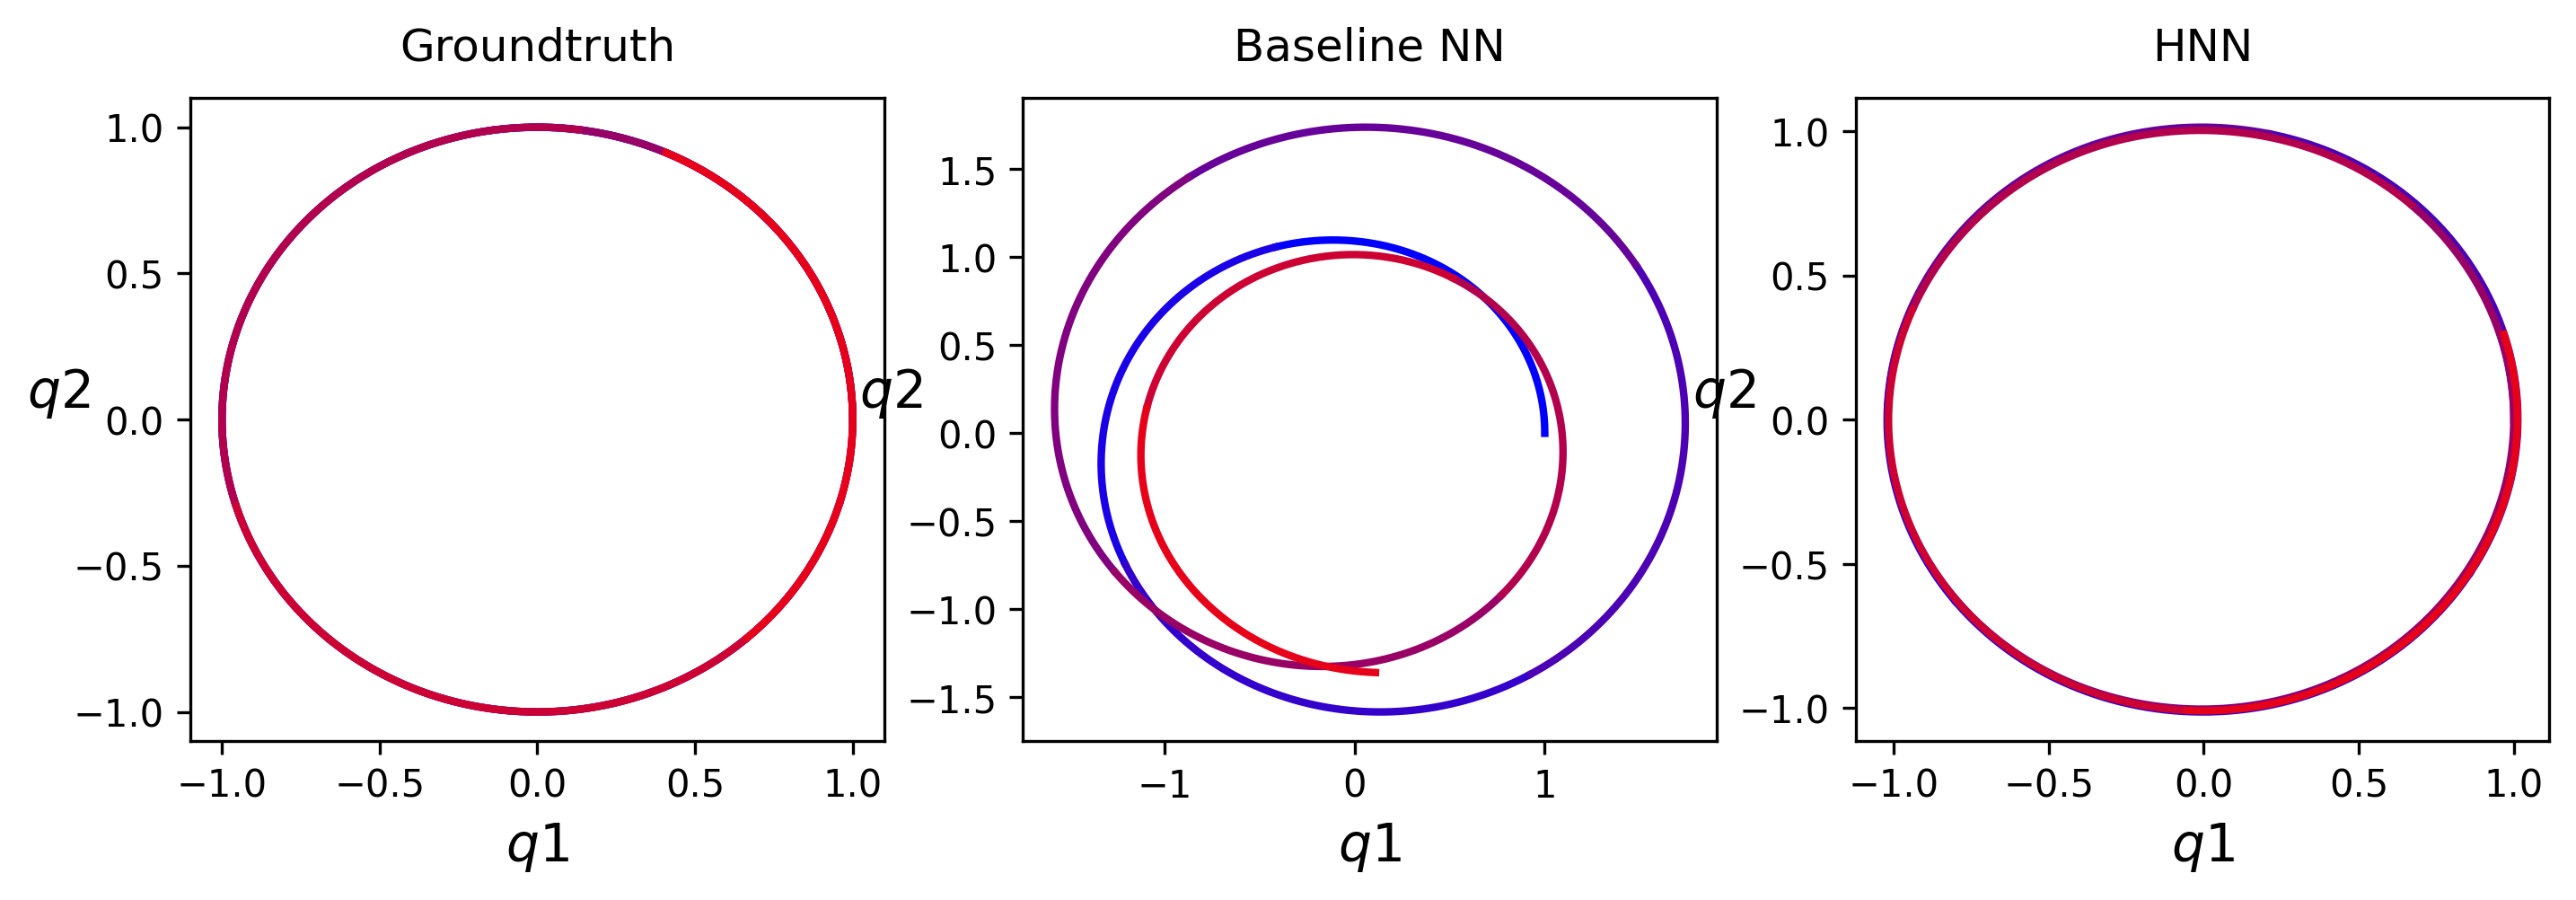

In [ ]:
fig = plt.figure(figsize=(11.3, 3.1), facecolor='white', dpi=DPI)

#plot ground truth
fig.add_subplot(1, 3, 1, frameon=True)

for i, l in enumerate(np.split(integrate_true['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1], color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q1$", fontsize=14)
plt.ylabel("$q2$", rotation=0, fontsize=14)
plt.title("Groundtruth", pad=10)

# plot baseline
fig.add_subplot(1, 3, 2, frameon=True)

for i, l in enumerate(np.split(integrate_model_bnn['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q1$", fontsize=14)
plt.ylabel("$q2$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot HNN
fig.add_subplot(1, 3, 3, frameon=True)

for i, l in enumerate(np.split(integrate_model_hnn['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q1$", fontsize=14)
plt.ylabel("$q2$", rotation=0, fontsize=14)
plt.title("HNN", pad=10)

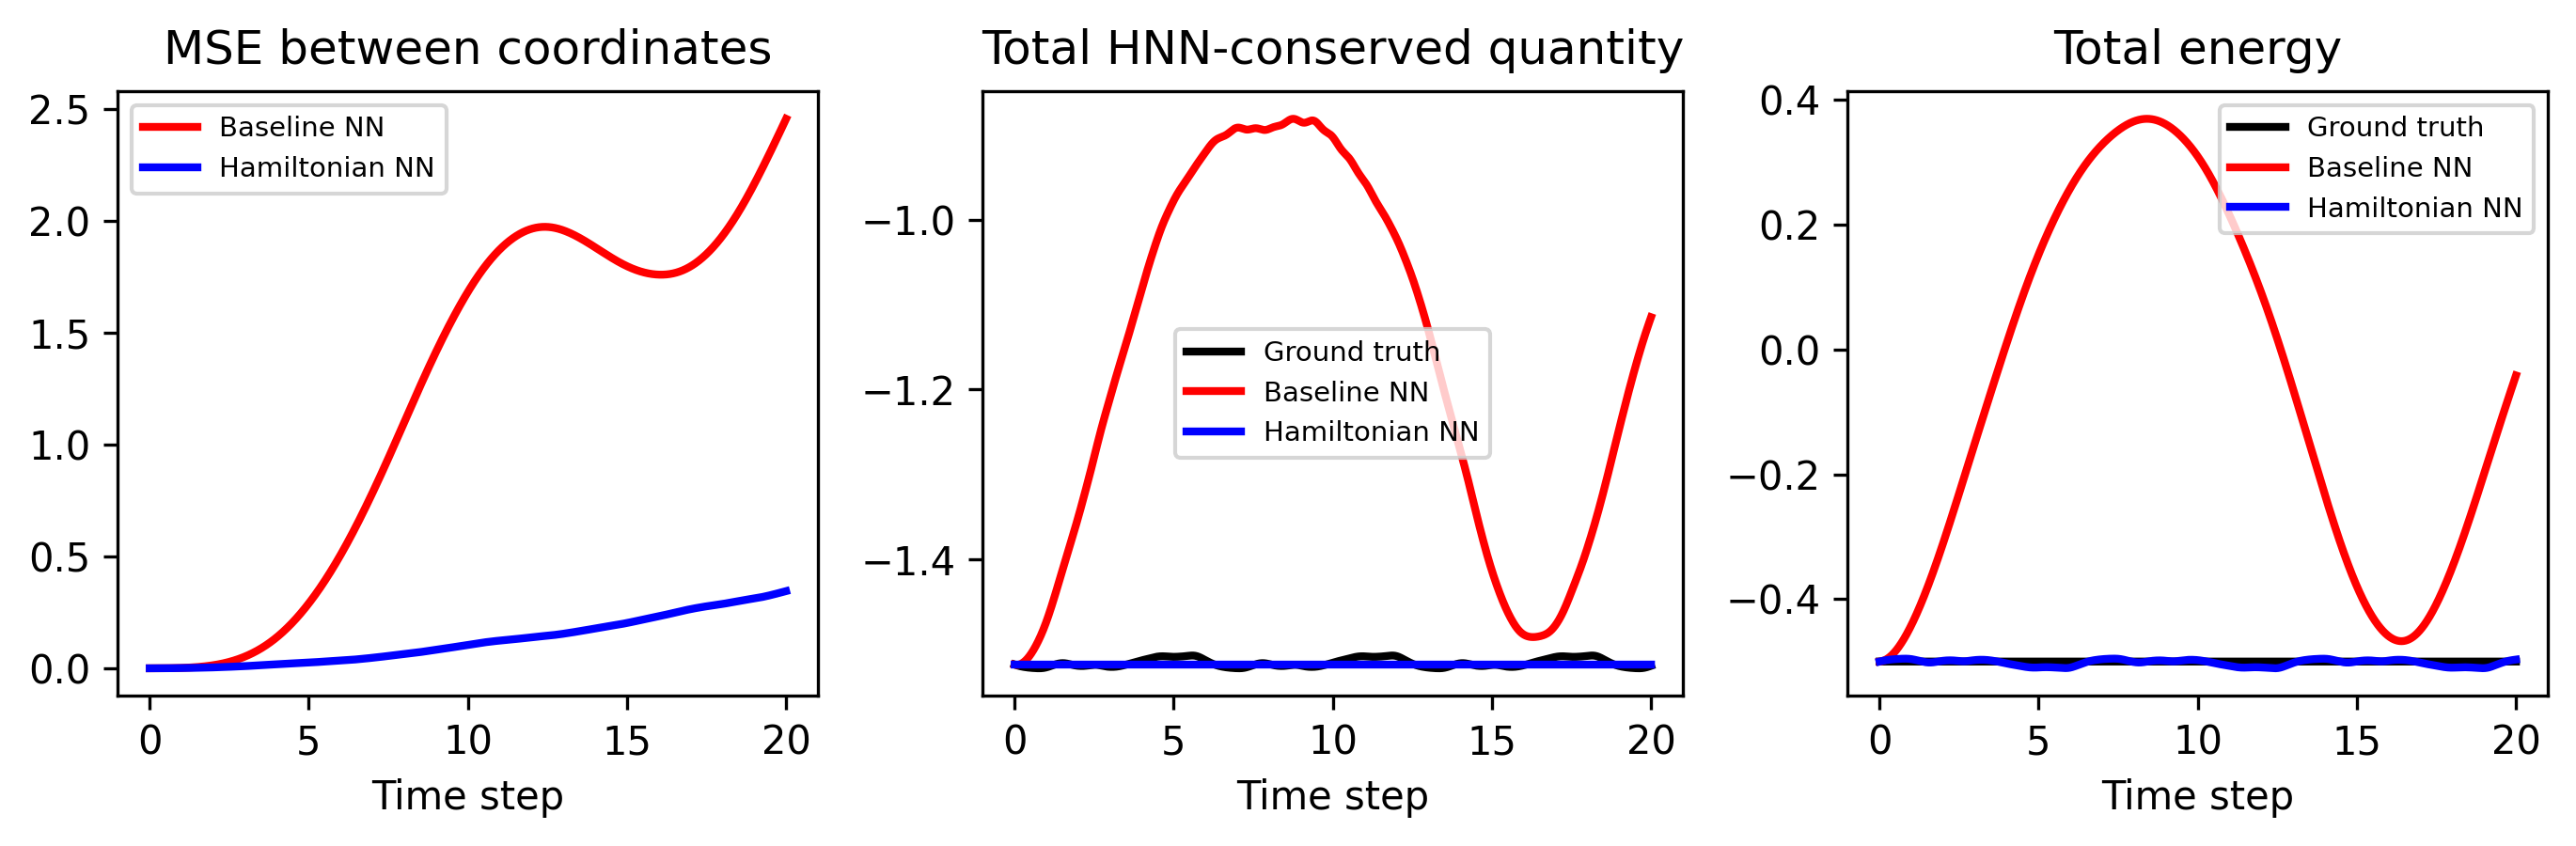

BNNによる予測エネルギーがep_nbdを外れる時間 0.019
HNNによる予測エネルギーがep_nbdを外れる時間 0.2835


In [ ]:
fig = plt.figure(figsize=(12.3, 3.1), facecolor='white', dpi=DPI)
tpad =7
noise_std = 0.0   #ノイズの設定を忘れないこと
t_span = [0,20]
y0=np.asarray([1.0, 0.0, 0.0, 1.0])
t_eval=np.linspace(t_span[0], t_span[1], 2000)

# integrate along ground truth vector field
true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-12)
true_y = true_path['y'].T

# ノイズの影響を補正するために時間を再スケールする必要があることに注意
t_span[1] *= 1 + .9*noise_std
t_eval *= 1 + .9*noise_std

# integrate along baseline vector field
base_path = integrate_model(model_bnn, y0=y0, t_span=t_span, t_eval=t_eval, rtol=1e-12)
base_y = base_path['y'].T

# integrate along HNN vector field
hnn_path = integrate_model(model_hnn, y0=y0, t_span=t_span, t_eval=t_eval, baseline=False, rtol=1e-12)
hnn_y = hnn_path['y'].T

plt.subplot(1,4,1)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_y-base_y)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_y-hnn_y)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,2)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq = model_hnn(torch.Tensor(true_y)).detach().numpy().squeeze()
base_hq = model_hnn(torch.Tensor(base_y)).detach().numpy().squeeze()
hnn_hq = model_hnn(torch.Tensor(hnn_y)).detach().numpy().squeeze()
plt.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,4,3)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e = np.stack([hamiltonian_fn(c) for c in true_y]).squeeze()
base_e = np.stack([hamiltonian_fn(c) for c in base_y]).squeeze()
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_y]).squeeze()
plt.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)
plt.tight_layout() ; plt.show()

ep_nbd = 0.01
for num in range(0,2000):
    if abs(true_e[num]-base_e[num]) > ep_nbd:
        print("BNNによる予測エネルギーがep_nbdを外れる時間",num*(1+.9*noise_std)/2000)
        break
    if num == 1999:
        print("BNNによる予測エネルギーはep_nbdを外れない")

for num in range(0,2000):
    if abs(true_e[num]-hnn_e[num]) > ep_nbd:
        print("HNNによる予測エネルギーがep_nbdを外れる時間",num*(1+.9*noise_std)/2000)
        break
    if num == 1999:
        print("HNNによる予測エネルギーはep_nbdを外れない")

In [ ]:
import copy
model_bnn_ext, stats_bnn_ext = train(baseline=True, total_steps=5000, data=data_ext)
model_hnn_copy = copy.deepcopy(model_hnn)
model_forced_hnn, stats_forced_hnn = train(baseline=False, total_steps=5000, data=data_ext, ext=True, hnn_model=model_hnn_copy)

Training baseline model:
step 0, train_loss 4.3029e-01, test_loss 3.0642e-01
step 200, train_loss 8.8580e-04, test_loss 8.1926e-04
step 400, train_loss 8.4684e-04, test_loss 8.2040e-04
step 600, train_loss 8.6473e-04, test_loss 8.3885e-04
step 800, train_loss 7.7308e-04, test_loss 8.3380e-04
step 1000, train_loss 7.2995e-04, test_loss 8.4698e-04
step 1200, train_loss 7.5516e-04, test_loss 8.4739e-04
step 1400, train_loss 9.8946e-04, test_loss 8.0665e-04
step 1600, train_loss 7.1554e-04, test_loss 9.0028e-04
step 1800, train_loss 9.1748e-04, test_loss 8.7979e-04
step 2000, train_loss 9.8297e-04, test_loss 9.0435e-04
step 2200, train_loss 1.0227e-03, test_loss 9.8069e-04
step 2400, train_loss 9.8337e-04, test_loss 8.8131e-04
step 2600, train_loss 9.4414e-04, test_loss 1.0308e-03
step 2800, train_loss 9.9253e-04, test_loss 7.8474e-04
step 3000, train_loss 8.4051e-04, test_loss 8.5531e-04
step 3200, train_loss 1.0388e-03, test_loss 8.0795e-04
step 3400, train_loss 9.9939e-04, test_loss 8.7

In [ ]:
t_span = [0,15]
t_eval=np.linspace(t_span[0], t_span[1], 2000)
integrate_true_ext = integrate(ext=True,t_span=t_span,t_eval=t_eval)
integrate_model_bnn_ext = integrate_model(model_bnn_ext,ext=True,t_span=t_span,t_eval=t_eval)
integrate_model_forced_hnn = integrate_model(model_forced_hnn, baseline=False,ext=True,t_span=t_span,t_eval=t_eval)

Text(0.5, 1.0, 'Forced HNN')

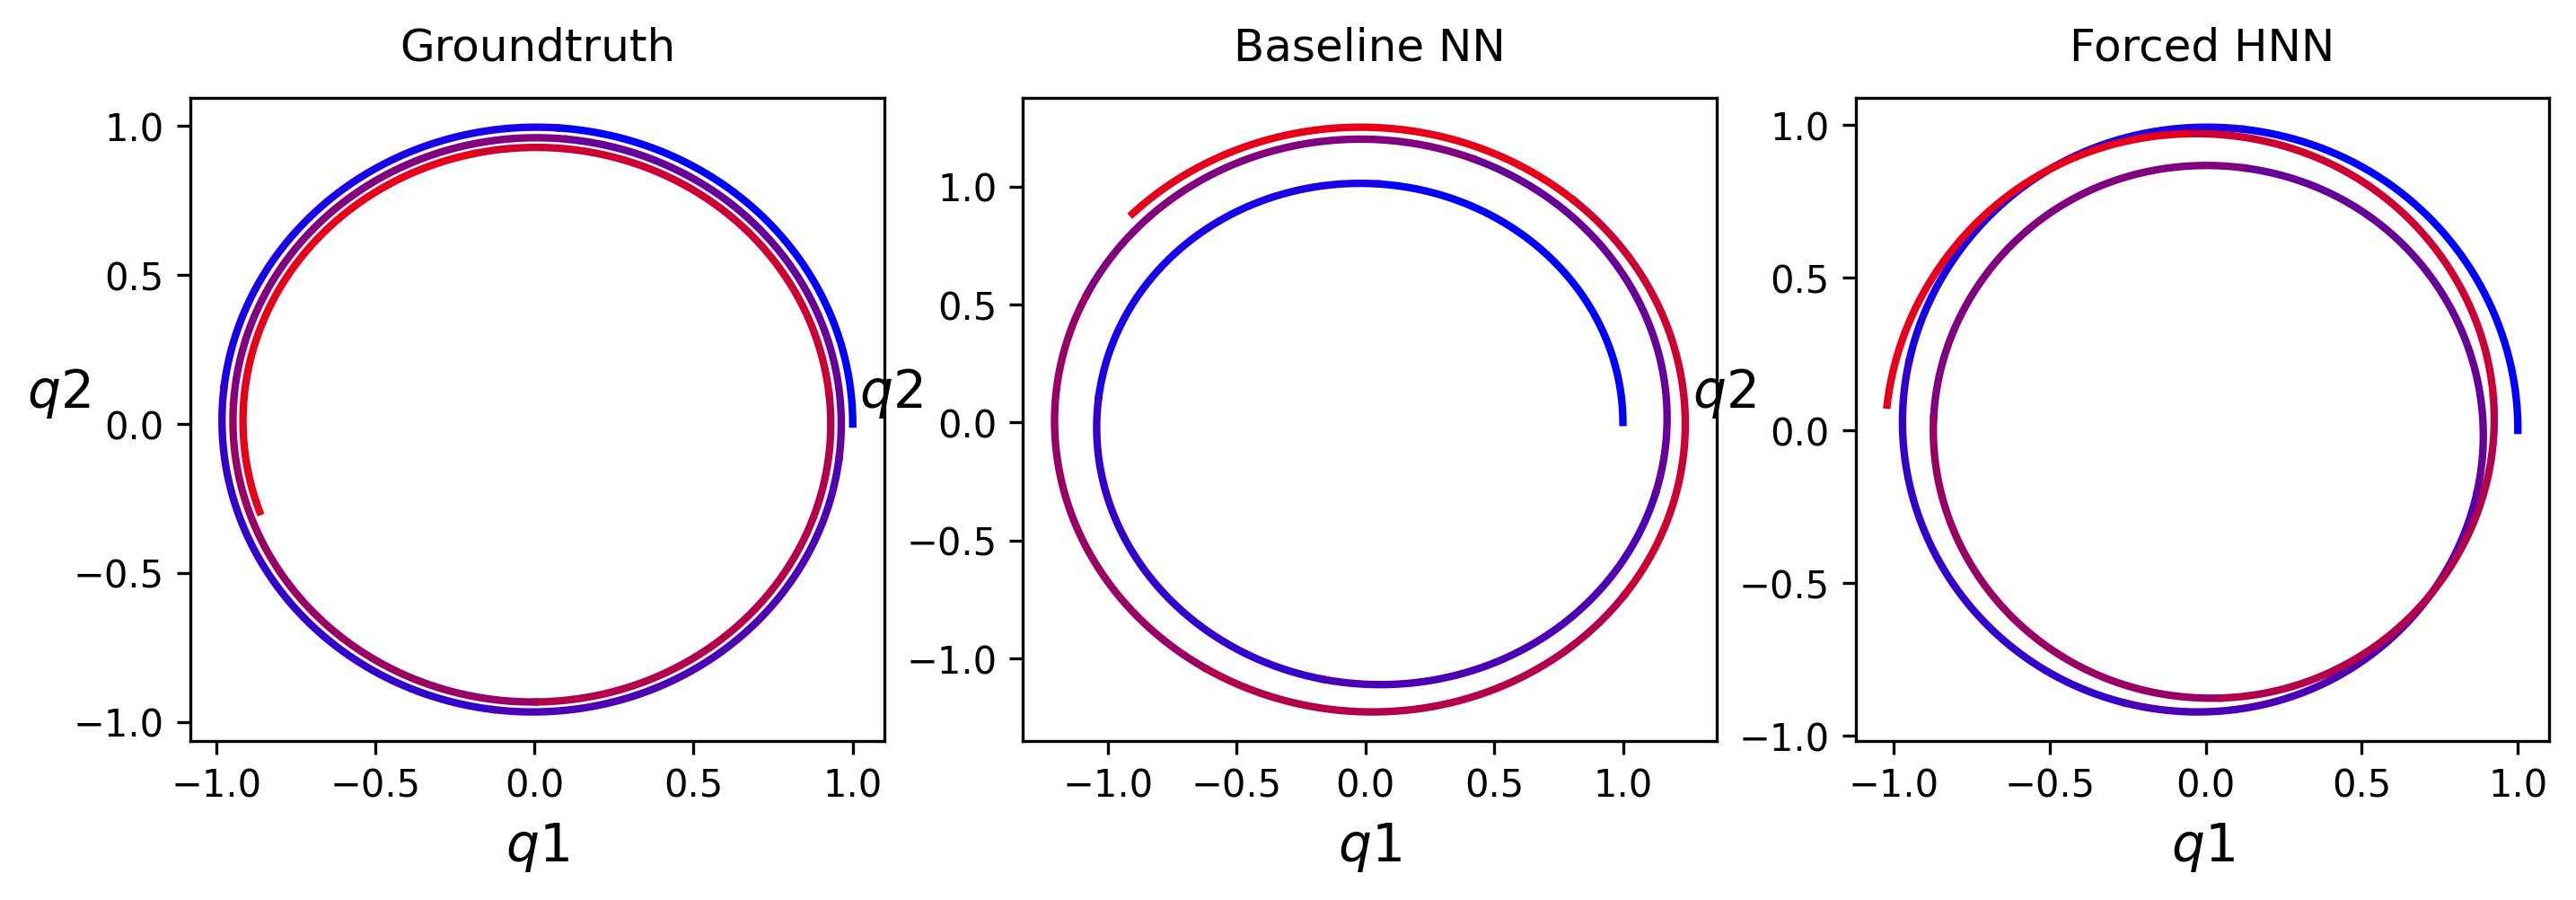

In [ ]:
fig = plt.figure(figsize=(11.3, 3.1), facecolor='white', dpi=DPI)

#plot ground truth
fig.add_subplot(1, 3, 1, frameon=True)

for i, l in enumerate(np.split(integrate_true_ext['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1], color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q1$", fontsize=14)
plt.ylabel("$q2$", rotation=0, fontsize=14)
plt.title("Groundtruth", pad=10)

# plot baseline ext
fig.add_subplot(1, 3, 2, frameon=True)

for i, l in enumerate(np.split(integrate_model_bnn_ext['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q1$", fontsize=14)
plt.ylabel("$q2$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot myHNN
fig.add_subplot(1, 3, 3, frameon=True)

for i, l in enumerate(np.split(integrate_model_forced_hnn['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q1$", fontsize=14)
plt.ylabel("$q2$", rotation=0, fontsize=14)
plt.title("Forced HNN", pad=10)

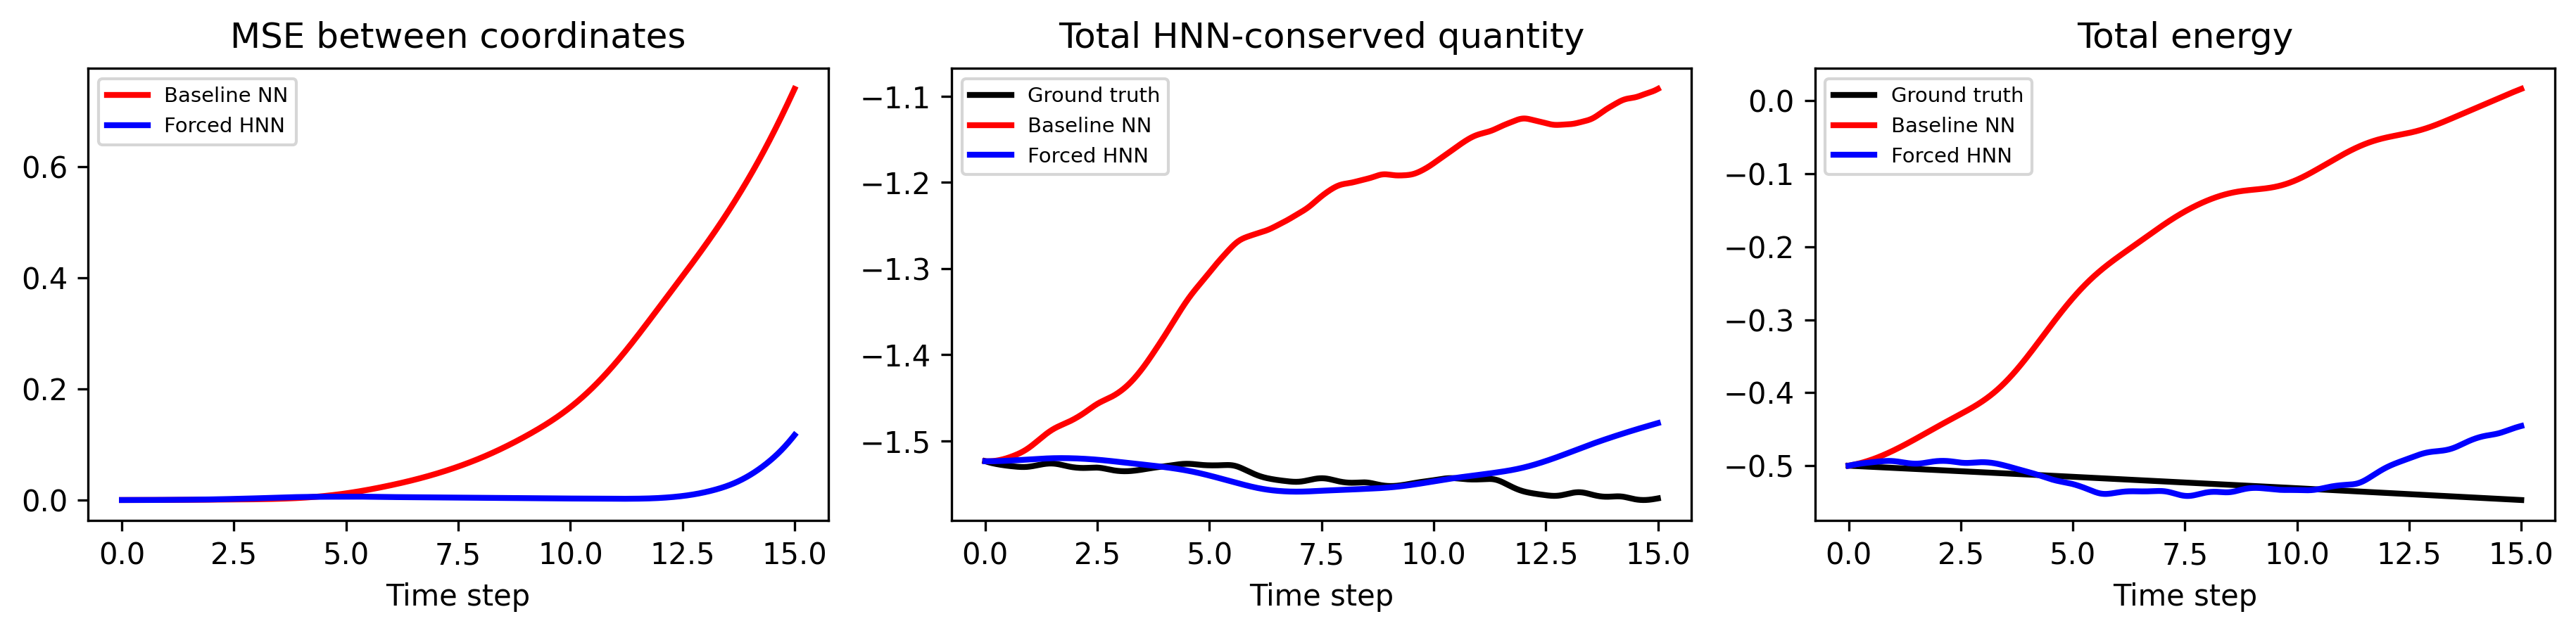

BNNによる予測エネルギーがep_nbdを外れる時間 0.035
Forced HNNによる予測エネルギーがep_nbdを外れる時間 0.1185


In [ ]:
fig = plt.figure(figsize=(12.3, 3.1), facecolor='white', dpi=DPI)
tpad =7
noise_std = 0.0   #ノイズの設定を忘れないこと
t_span = [0,15]
y0=np.asarray([1.0, 0.0, 0.0, 1.0])
t_eval=np.linspace(t_span[0], t_span[1], 2000)

# integrate along ground truth vector field
true_path_ext = solve_ivp(fun=dynamics_fn_ext, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-12)
true_y_ext = true_path_ext['y'].T

# ノイズの影響を補正するために時間を再スケールする必要があることに注意
t_span[1] *= 1 + .7*noise_std
t_eval *= 1 + .7*noise_std

# integrate along baseline vector field
base_path_ext = integrate_model(model_bnn_ext, y0=y0, t_span=t_span, t_eval=t_eval, rtol=1e-12)
base_y_ext = base_path_ext['y'].T

# integrate along  Forced HNN vector field
forced_hnn_path = integrate_model(model_forced_hnn, y0=y0, t_span=t_span, t_eval=t_eval, baseline=False, rtol=1e-12)
forced_hnn_y = forced_hnn_path['y'].T

plt.subplot(1,3,1)
plt.title("MSE between coordinates", pad=tpad) ; plt.xlabel('Time step')
plt.plot(t_eval, ((true_y_ext-base_y_ext)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_y_ext-forced_hnn_y)**2).mean(-1), 'b-', label='Forced HNN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,3,2)
plt.title("Total HNN-conserved quantity", pad=tpad)
plt.xlabel('Time step')
true_hq_ext = model_hnn(torch.Tensor(true_y_ext)).detach().numpy().squeeze()
base_hq_ext = model_hnn(torch.Tensor(base_y_ext)).detach().numpy().squeeze()
forced_hnn_hq = model_hnn(torch.Tensor(forced_hnn_y)).detach().numpy().squeeze()
plt.plot(t_eval, true_hq_ext, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_hq_ext, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, forced_hnn_hq, 'b-', label='Forced HNN', linewidth=2)
plt.legend(fontsize=7)

plt.subplot(1,3,3)
plt.title("Total energy", pad=tpad)
plt.xlabel('Time step')
true_e_ext = np.stack([hamiltonian_fn(c) for c in true_y_ext])
base_e_ext = np.stack([hamiltonian_fn(c) for c in base_y_ext])
forced_hnn_e = np.stack([hamiltonian_fn(c) for c in forced_hnn_y])
plt.plot(t_eval, true_e_ext, 'k-', label='Ground truth', linewidth=2)
plt.plot(t_eval, base_e_ext, 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, forced_hnn_e, 'b-', label='Forced HNN', linewidth=2)
plt.legend(fontsize=7)

plt.tight_layout() ; plt.show()

ep_nbd = 0.01
for num in range(0,2000):
    if abs(true_e_ext[num]-base_e_ext[num]) > ep_nbd:
        print("BNNによる予測エネルギーがep_nbdを外れる時間",num*(1+.9*noise_std)/2000)
        break
    if num == 1999:
        print("BNNによる予測エネルギーはep_nbdを外れない")

for num in range(0,2000):
    if abs(true_e_ext[num]-forced_hnn_e[num]) > ep_nbd:
        print("Forced HNNによる予測エネルギーがep_nbdを外れる時間",num*(1+.9*noise_std)/2000)
        break
    if num == 1999:
        print(" Forced HNNによる予測エネルギーはep_nbdを外れない")